# Lending Club Risk Adjusted Interest Rate Prediction

Created by Yuxi Chen on 10/6/2018

Predict interest rate for lending club loans to manage risk.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [4]:
location='/Users/yuxi/Downloads/loan.csv'
my_data=pd.read_csv(location)
df=my_data
df.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1069639,1304742,7000.0,7000.0,7000.0,60 months,15.96,170.08,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1072053,1288686,3000.0,3000.0,3000.0,36 months,18.64,109.43,E,E1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1071795,1306957,5600.0,5600.0,5600.0,60 months,21.28,152.39,F,F2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1071570,1306721,5375.0,5375.0,5350.0,60 months,12.69,121.45,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
df.shape

(887379, 74)

## Missing Value Imputation

In [182]:
na_cols = df.shape[0]-df.count()
na_cols[na_cols>0]

emp_title                       51462
emp_length                      44825
annual_inc                          4
desc                           761351
title                             152
delinq_2yrs                        29
earliest_cr_line                   29
inq_last_6mths                     29
mths_since_last_delinq         454312
mths_since_last_record         750326
open_acc                           29
pub_rec                            29
revol_util                        502
total_acc                          29
last_pymnt_d                    17659
next_pymnt_d                   252971
last_credit_pull_d                 53
collections_12_mths_ex_med        145
mths_since_last_major_derog    665676
annual_inc_joint               886868
dti_joint                      886870
verification_status_joint      886868
acc_now_delinq                     29
tot_coll_amt                    70276
tot_cur_bal                     70276
open_acc_6m                    866007
open_il_6m  

Impute missing values of annual income

In [183]:
print 'annual income mean: ', df['annual_inc'].mean(), ' median: ', df['annual_inc'].median()

annual income mean:  75027.5877608  median:  65000.0


In [5]:
# fill the NA values of annual income with its median, as its dist'n is right skewed
df['annual_inc'] = df['annual_inc'].fillna(value=df['annual_inc'].median())
len(df['annual_inc'])-df['annual_inc'].count()

0

** TO BE IMPROVED ** - KNN? Check relationship with other features by boxplot?

In [6]:
print 'total_acc median: ', df['total_acc'].median(), df['total_acc'].describe()
print 'tot_cur_bal median: ', df['tot_cur_bal'].median(), df['tot_cur_bal'].describe()
print 'open_acc median: ', df['open_acc'].median(), df['open_acc'].describe()
df['total_acc'] = df['total_acc'].fillna(value=df['total_acc'].median())
df['tot_cur_bal'] = df['tot_cur_bal'].fillna(value=df['tot_cur_bal'].median())
df['open_acc'] = df['open_acc'].fillna(value=df['open_acc'].median())

total_acc median:  24.0 count    887350.000000
mean         25.268026
std          11.840561
min           1.000000
25%          17.000000
50%          24.000000
75%          32.000000
max         169.000000
Name: total_acc, dtype: float64
tot_cur_bal median:  80559.0 count    8.171030e+05
mean     1.394582e+05
std      1.537500e+05
min      0.000000e+00
25%      2.985300e+04
50%      8.055900e+04
75%      2.082050e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64
open_acc median:  11.0 count    887350.000000
mean         11.548469
std           5.317313
min           0.000000
25%           8.000000
50%          11.000000
75%          14.000000
max          90.000000
Name: open_acc, dtype: float64


## Remove useless features
* Remove most of loan payment related features, since payments were made after interest rates were determined. Hence, they should not be used to predict interest rate.  
* Remove features with unique value per row and with same value across rows (no variance): policy_code, id, member_id, url  
* Remove redundant features: dti_joint, annual_income_joint, and application_type which indicates wheter it's a joint loan, and verification_status_joint
* Drop the features with more than 80% values missing
* Remove emp_title, desc, title, which require text mining
* Remove zip_code, which require external information

In [7]:
df.drop('installment',axis=1,inplace=True)
df.drop('funded_amnt',axis=1,inplace=True)
df.drop('funded_amnt_inv',axis=1,inplace=True)
df.drop('last_pymnt_amnt',axis=1,inplace=True)
df.drop('last_pymnt_d',axis=1,inplace=True)
df.drop('next_pymnt_d',axis=1,inplace=True)
df.drop('recoveries',axis=1,inplace=True)
df.drop('total_pymnt',axis=1,inplace=True)
df.drop('total_pymnt_inv',axis=1,inplace=True)
df.drop('total_rec_int',axis=1,inplace=True)
df.drop('total_rec_late_fee',axis=1,inplace=True)
df.drop('total_rec_prncp',axis=1,inplace=True)
df.drop('collection_recovery_fee',axis=1,inplace=True)
df.drop('out_prncp',axis=1,inplace=True)
df.drop('out_prncp_inv',axis=1,inplace=True)

In [8]:
df['policy_code'].unique() # drop policy code since all loans have policy_code=1
df.drop('policy_code',axis=1,inplace=True)

In [9]:
df.drop('id',axis=1,inplace=True)
df.drop('member_id',axis=1,inplace=True)
df.drop('url',axis=1,inplace=True)
df.shape

(887379, 55)

In [10]:
print 'count dti_joint:',df['dti_joint'].count()
print 'annual_inc_joint:',df['annual_inc_joint'].count()
print df[df['dti_joint'].isnull()==False][['dti','dti_joint']].head()
print df[df['annual_inc_joint'].isnull()==False][['annual_inc','annual_inc_joint']].head()
df['dti_2'] = df['dti_joint'].fillna(df['dti'])
df['annual_inc_2'] = df['annual_inc_joint'].fillna(df['annual_inc'])

count dti_joint: 509
annual_inc_joint: 511
          dti  dti_joint
466289  10.78      13.85
466419  20.67      16.40
466741  17.56      15.40
466850  22.70      22.76
466914  46.71      17.07
        annual_inc  annual_inc_joint
466289    63000.00          71000.00
466419    75000.00         100000.00
466741    65000.00          77000.00
466850    96000.00         117000.00
466914    29524.32          94348.32


In [11]:
df.drop('dti',axis=1,inplace=True)
df.drop('dti_joint',axis=1,inplace=True)
df.drop('annual_inc',axis=1,inplace=True)
df.drop('annual_inc_joint',axis=1,inplace=True)
df.shape

(887379, 53)

In [12]:
# hence also drop application type and verification_status_joint
df.drop('application_type',axis=1,inplace=True)
df.drop('verification_status_joint',axis=1,inplace=True)

In [13]:
# Drop the features with more than 80% values missing
df = df.dropna(axis=1,thresh=len(df)*0.8)
na_cols = df.shape[0]-df.count()
na_cols[na_cols>0]
df.shape

(887379, 33)

In [14]:
df.drop('emp_title',axis=1,inplace=True)
df.drop('title',axis=1,inplace=True)
df.drop('zip_code',axis=1,inplace=True)

In [15]:
# check number of features left
df.shape

(887379, 30)

## Collapse levels of the categorical features w/ too many levels

 **ADDR_STATE**: 51 levels

In [16]:
state_int_mean=df.groupby('addr_state').mean()['int_rate']
state_int_mean.describe()

count    51.000000
mean     13.202830
std       0.382424
min      11.345833
25%      13.080990
50%      13.288569
75%      13.412399
max      13.922619
Name: int_rate, dtype: float64

In [17]:
low=[]
medium_low=[]
medium_high=[]
high=[]
for x in df['addr_state'].unique():
    if state_int_mean[x] <= state_int_mean.describe()['25%']:
        low.append(x)
    elif state_int_mean[x]>state_int_mean.describe()['25%'] and state_int_mean[x]<=state_int_mean.mean():
        medium_low.append(x)
    elif state_int_mean[x]>state_int_mean.mean() and state_int_mean[x]<=state_int_mean.describe()['75%']:
        medium_high.append(x)
    else:
        high.append(x)

def collapse(x): 
    if x in low:
        return 'low'
    if x in medium_low:
        return 'medium_low'
    if x in medium_high:
        return 'medium_high'
    else:
        return 'high'

df['addr_state_2']=df['addr_state'].apply(collapse)
    

In [18]:
df['addr_state_2'].unique()

array(['medium_low', 'medium_high', 'high', 'low'], dtype=object)

In [19]:
print high, 'are risky states'

['NC', 'SC', 'AL', 'NV', 'AK', 'SD', 'AR', 'HI', 'OK', 'DE', 'MS', 'TN', 'IN'] are risky states


** LOAN STATUS **

In [20]:
df['loan_status'] = df['loan_status'].str.replace('Does not meet the credit policy. Status.', '')
df['loan_status_2'] = df['loan_status'].apply(lambda x: 'okay' if x in ['Current','Fully Paid','In Grace Period'] else 'warning')
df.groupby('loan_status_2').count()

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,loan_status,...,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,dti_2,annual_inc_2,addr_state_2
loan_status_2,,,,,,,,,,,,,,,,,,,,,
okay,817743,817743,817743,817743,817743,777021,817743,817743,817743,817743,...,817743,817697,817626,817717,758413,817743,758413,817743,817743,817743
warning,69636,69636,69636,69636,69636,65533,69636,69636,69636,69636,...,69636,69629,69608,69633,58690,69636,58690,69636,69636,69636


** LOAN PURPOSE **  
From EDA, credit card, car and educational loans have lower interest rate on average. Collapse these three into one level and the rest into one.

In [21]:
# one hot: 0 for credit_card, car, educational, 1 for the others
df['purpose_2'] = df['purpose'].apply(lambda x: 0 if x in ['credit_card', 'car', 'educational'] else 1)
df.groupby('purpose_2').count()

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,loan_status,...,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,dti_2,annual_inc_2,addr_state_2,loan_status_2
purpose_2,,,,,,,,,,,,,,,,,,,,,
0,215468,215468,215468,215468,215468,203840,215468,215468,215468,215468,...,215456,215421,215468,202194,215468,202194,215468,215468,215468,215468
1,671911,671911,671911,671911,671911,638714,671911,671911,671911,671911,...,671870,671813,671882,614909,671911,614909,671911,671911,671911,671911


#### HOME OWNERSHIP

In [140]:
# merge 'ANY','NONE' into 'OTHER'
df['home_ownership'] = df['home_ownership'].apply(lambda x: 'OTHER' if x in ['ANY','NONE'] else x)
df['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

# Model fitting 

In [22]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math

## Baseline - Linear Regression

### Model 1
int_rate ~ grade + term + addr_state_2 + annual_inc_2 + dti_2 + loan_amnt + total_acc + tot_cur_bal + open_acc + loan_status_2 + purpose + verification_status

**w/** annual_inc_2, dti_2, loan_amnt, total_acc, total_cur_bal, open_acc standardized **&** loan_status and addr_stat collapsed

** Standardize **
annual_inc_2, dti_2, loan_amnt, total_acc, total_cur_bal, open_acc

In [69]:
X=df.drop('int_rate',axis=1)
y=df['int_rate']
X[['annual_inc_2', 'dti_2', 'loan_amnt', 'total_acc', 'tot_cur_bal', 'open_acc']]=\
preprocessing.scale(df[['annual_inc_2', 'dti_2', 'loan_amnt', 'total_acc', 'tot_cur_bal', 'open_acc']])

** Train test split **

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

In [71]:
X_train_sub1 = X_train[['grade','term','addr_state_2','annual_inc_2', 'dti_2', 'loan_amnt', 'total_acc', \
                       'tot_cur_bal', 'open_acc', 'loan_status_2', 'purpose','verification_status']]
train_sub1=X_train_sub1
train_sub1['int_rate']=y_train

In [31]:
lm1 = smf.ols(formula='int_rate ~ grade + term + addr_state_2 + annual_inc_2 + dti_2 + loan_amnt + total_acc \
                    + tot_cur_bal + open_acc + loan_status_2 + purpose + verification_status', data=train_sub1).fit()
pred1 = lm1.predict(X_test)
print lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               int_rate   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 2.095e+05
Date:                Sat, 20 Oct 2018   Prob (F-statistic):               0.00
Time:                        15:02:53   Log-Likelihood:            -1.0329e+06
No. Observations:              621165   AIC:                         2.066e+06
Df Residuals:                  621132   BIC:                         2.066e+06
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  7.0534      0.017    406.998      0.000       7.019       7.087
grade[T.B]                                 3.5160      0.005    693.214      0.000       3.506       3.526
grade[T.C]                                 6.5919      0.005   1232.905      0.000       6.581       6.602
grade[T.D]                                 9.7353      0.006   1565.240      0.000       9.723       9.748
grade[T.E]                                12.3895      0.008   1592.311      0.000      12.374      12.405
grade[T.F]                                16.0015      0.012   1389.068      0.000      15.979      16.024
grade[T.G]                                18.0187      0.021    841.282      0.000      17.977      18.061
term[T. 60 months]                         0.1141      0.004     26.374      0.000       0.106       0.123
addr_state_2[T.low]                       -0.0332      0.007     -4.691      0.000      -0.047      -0.019
addr_state_2[T.medium_high]                0.0026      0.005      0.498      0.618      -0.008       0.013
addr_state_2[T.medium_low]                 0.0132      0.005      2.517      0.012       0.003       0.024
loan_status_2[T.warning]                   0.4132      0.006     67.868      0.000       0.401       0.425
purpose[T.credit_card]                     0.0261      0.017      1.566      0.117      -0.007       0.059
purpose[T.debt_consolidation]              0.1423      0.016      8.639      0.000       0.110       0.175
purpose[T.educational]                    -0.8576      0.077    -11.105      0.000      -1.009      -0.706
purpose[T.home_improvement]                0.0610      0.018      3.459      0.001       0.026       0.096
purpose[T.house]                           0.3255      0.030     10.861      0.000       0.267       0.384
purpose[T.major_purchase]                  0.0274      0.020      1.372      0.170      -0.012       0.067
purpose[T.medical]                         0.1473      0.023      6.342      0.000       0.102       0.193
purpose[T.moving]                          0.2582      0.026      9.768      0.000       0.206       0.310
purpose[T.other]                           0.2055      0.018     11.483      0.000       0.170       0.241
purpose[T.renewable_energy]                0.1639      0.064      2.554      0.011       0.038       0.290
purpose[T.small_business]                  0.1606      0.022      7.218      0.000       0.117       0.204
purpose[T.vacation]                        0.1850      0.028      6.723      0.000       0.131       0.239
purpose[T.wedding]                         0.4710      0.036     13.143      0.000       0.401       0.541
verification_status[T.Source Verified]     0.0171      0.004      4.167      0.000     

In [32]:
print 'RMSE:', math.sqrt(((pred1-y_test)**2).mean())
print 'MAE:', abs(pred1-y_test).mean()

RMSE: 1.27810191713
MAE: 1.02685047552


### Model 2
int_rate ~ grade + term + addr_state_2 + annual_inc_2 + dti_2 + loan_amnt + total_acc + tot_cur_bal + open_acc + loan_status_2 + purpose_2 + verification_status

**w/** collapsed purpose

In [72]:
X_train_sub2 = X_train[['grade','term','addr_state_2','annual_inc_2', 'dti_2', 'loan_amnt', 'total_acc', \
                       'tot_cur_bal', 'open_acc', 'loan_status_2', 'purpose_2', 'verification_status']]
train_sub2=X_train_sub2
train_sub2['int_rate']=y_train
lm2 = smf.ols(formula='int_rate ~ grade + term + addr_state_2 + annual_inc_2 + dti_2 + loan_amnt + total_acc \
                    + tot_cur_bal + open_acc + loan_status_2 + purpose_2 + verification_status', data=train_sub2).fit()
pred2 = lm2.predict(X_test)
print lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               int_rate   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 3.348e+05
Date:                Sat, 20 Oct 2018   Prob (F-statistic):               0.00
Time:                        17:03:41   Log-Likelihood:            -1.0332e+06
No. Observations:              621165   AIC:                         2.067e+06
Df Residuals:                  621144   BIC:                         2.067e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  7.0728      0.007   1056.720      0.000       7.060       7.086
grade[T.B]                                 3.5184      0.005    693.680      0.000       3.508       3.528
grade[T.C]                                 6.5968      0.005   1235.924      0.000       6.586       6.607
grade[T.D]                                 9.7438      0.006   1574.493      0.000       9.732       9.756
grade[T.E]                                12.3996      0.008   1602.825      0.000      12.384      12.415
grade[T.F]                                16.0147      0.011   1397.086      0.000      15.992      16.037
grade[T.G]                                18.0355      0.021    844.343      0.000      17.994      18.077
term[T. 60 months]                         0.1095      0.004     25.367      0.000       0.101       0.118
addr_state_2[T.low]                       -0.0322      0.007     -4.544      0.000      -0.046      -0.018
addr_state_2[T.medium_high]                0.0034      0.005      0.651      0.515      -0.007       0.013
addr_state_2[T.medium_low]                 0.0149      0.005      2.836      0.005       0.005       0.025
loan_status_2[T.warning]                   0.4137      0.006     67.936      0.000       0.402       0.426
verification_status[T.Source Verified]     0.0180      0.004      4.382      0.000       0.010       0.026
verification_status[T.Verified]            0.3810      0.004     87.220      0.000       0.372       0.390
annual_inc_2                              -0.0357      0.002    -19.444      0.000      -0.039      -0.032
dti_2                                     -0.0115      0.002     -6.423      0.000      -0.015      -0.008
loan_amnt                                  0.0036      0.002      1.792      0.073      -0.000       0.008
total_acc                                  0.0053      0.002      2.307      0.021       0.001       0.010
tot_cur_bal                               -0.0338      0.002    -18.030      0.000      -0.037      -0.030
open_acc                                  -0.0361      0.002    -15.586      0.000      -0.041      -0.032
purpose_2                                  0.1161      0.004     30.038      0.000       0.109       0.124
==============================================================================
Omnibus:                    14532.563   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32557.654
Skew:                          -0.082   Prob(JB):                         0.00
Kurtosis:                       4.109   Cond. No.                         21.2
==============================================================================

Warnings:
[1] Standard Errors assume tha

In [74]:
print 'RMSE:', math.sqrt(((pred2-y_test)**2).mean())
print 'MAE:', abs(pred2-y_test).mean()

RMSE: 1.27895600474
MAE: 1.0275546069


Adjusted R^2 stays the same, smaller AIC and BIC, MAE slightly increased

### Model 3
int_rate ~ grade + term + addr_state_2 + annual_inc_2 + dti_2 + loan_amnt + total_acc + tot_cur_bal + open_acc + loan_status_2 + purpose_2 + verification_status

**w/** annual_inc_2, dti_2, loan_amnt, total_acc, total_cur_bal, open_acc transformed, since they are left/right skewed (from EDA)

** Box-Cox transformation + Standardization **

In [40]:
X=df.drop('int_rate',axis=1)
y=df['int_rate']
ls=['annual_inc_2', 'dti_2', 'loan_amnt', 'total_acc', 'tot_cur_bal', 'open_acc']
for i in ls:
    X[i]=stats.boxcox(df[i]+0.01)[0]
X[ls]=preprocessing.scale(X[ls])

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)
X_train_sub3 = X_train[['grade','term','addr_state_2','annual_inc_2', 'dti_2', 'loan_amnt', 'total_acc', \
                       'tot_cur_bal', 'open_acc', 'loan_status_2', 'purpose_2', 'verification_status']]
train_sub3=X_train_sub3
train_sub3['int_rate']=y_train
lm3 = smf.ols(formula='int_rate ~ grade + term + addr_state_2 + annual_inc_2 + dti_2 + loan_amnt + total_acc \
                    + tot_cur_bal + open_acc + loan_status_2 + purpose_2 + verification_status', data=train_sub3).fit()
pred3 = lm3.predict(X_test)
print lm3.summary()

                            OLS Regression Results                            
Dep. Variable:               int_rate   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 3.350e+05
Date:                Wed, 24 Oct 2018   Prob (F-statistic):               0.00
Time:                        14:38:06   Log-Likelihood:            -1.0331e+06
No. Observations:              621165   AIC:                         2.066e+06
Df Residuals:                  621144   BIC:                         2.066e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [77]:
print 'RMSE:', math.sqrt(((pred3-y_test)**2).mean())
print 'MAE:', abs(pred3-y_test).mean()

RMSE: 1.2787327932
MAE: 1.0272990774


Slightly smaller RMSE and MAE, and coefficients of the numerical variables all become statistically significant (w/ pvalue=0.0)

### Residual Plot

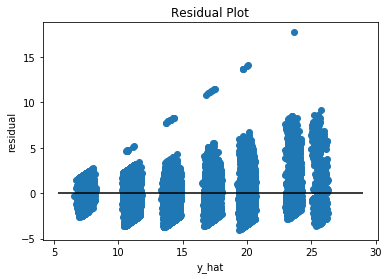

In [50]:
plt.scatter(pred3,(pred3-y_test))
plt.hlines(y=0,xmin=y_test.min(),xmax=y_test.max())
plt.title('Residual Plot')
plt.xlabel('y_hat')
plt.ylabel('residual')
plt.show()

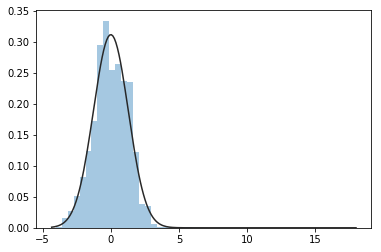

In [142]:
sns.distplot((pred3-y_test),kde=False,fit=stats.norm)

In [65]:
resid=pred3-y_test
test=pd.concat([y_test,X_test[['grade','term','addr_state_2','annual_inc_2', 'dti_2', 'loan_amnt', 'total_acc', \
                       'tot_cur_bal', 'open_acc', 'loan_status_2', 'purpose_2', 'verification_status']]],axis=1)
test[resid>(resid.mean()+3*(resid.std()))]

,int_rate,grade,term,addr_state_2,annual_inc_2,dti_2,loan_amnt,total_acc,tot_cur_bal,open_acc,loan_status_2,purpose_2,verification_status
42344,15.01,F,36 months,medium_high,-1.417752,0.658651,-0.432747,-0.979012,-0.026829,-0.607179,okay,1,Not Verified
42442,14.70,E,36 months,low,-2.128442,0.284217,-1.102948,-0.633291,-0.026829,1.073154,okay,1,Not Verified
39136,12.61,D,36 months,low,-1.254249,-0.349638,-0.582411,-1.104771,-0.026829,-1.185047,warning,1,Not Verified
37297,15.68,E,36 months,medium_high,-0.281137,0.159629,0.089736,-0.324875,-0.026829,-0.135645,okay,1,Not Verified
42387,17.86,G,36 months,medium_high,-0.888801,-0.583953,0.502939,-0.324875,-0.026829,-0.607179,warning,1,Not Verified
38358,14.93,E,36 months,medium_high,0.474089,-1.146545,-0.432747,-0.743829,-0.026829,-0.607179,okay,1,Not Verified
41669,12.61,D,36 months,medium_low,-0.904638,-0.888433,-0.567009,0.674814,-0.026829,0.616039,okay,1,Not Verified
18107,18.25,F,60 months,medium_high,-0.888801,0.164277,0.726035,-2.235922,-0.026829,-2.448622,okay,1,Verified
42067,18.04,G,36 months,medium_high,0.038319,0.511398,0.616482,-0.424157,-0.026829,0.928528,okay,1,Not Verified
41793,16.71,F,36 months,medium_high,-0.274141,1.001936,-0.312451,-0.526857,-0.026829,0.265433,okay,1,Not Verified


### WHAT ELSE?

In [68]:
df[['delinq_2yrs','int_rate']].corr()

,delinq_2yrs,int_rate
delinq_2yrs,1.000000,0.055178
int_rate,0.055178,1.000000


In [81]:
X['delinq_2yrs'] = X['delinq_2yrs'].fillna(value=df['delinq_2yrs'].median())
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)
X_train_sub4 = X_train[['grade','term','addr_state_2','annual_inc_2', 'dti_2', 'loan_amnt', 'total_acc', \
                       'tot_cur_bal', 'open_acc', 'loan_status_2', 'purpose_2', 'verification_status', 'delinq_2yrs']]
train_sub4=X_train_sub4
train_sub4['int_rate']=y_train
lm4 = smf.ols(formula='int_rate ~ grade + term + addr_state_2 + annual_inc_2 + dti_2 + loan_amnt + total_acc \
                    + tot_cur_bal + open_acc + loan_status_2 + purpose_2 + verification_status +delinq_2yrs', data=train_sub4).fit()
pred4 = lm4.predict(X_test)
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               int_rate   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 3.190e+05
Date:                Sat, 20 Oct 2018   Prob (F-statistic):               0.00
Time:                        17:18:41   Log-Likelihood:            -1.0331e+06
No. Observations:              621165   AIC:                         2.066e+06
Df Residuals:                  621143   BIC:                         2.066e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  7.0796      0.007   1056.476      0.000       7.066       7.093
grade[T.B]                                 3.5116      0.005    689.458      0.000       3.502       3.522
grade[T.C]                                 6.5841      0.005   1221.444      0.000       6.574       6.595
grade[T.D]                                 9.7266      0.006   1555.377      0.000       9.714       9.739
grade[T.E]                                12.3795      0.008   1587.106      0.000      12.364      12.395
grade[T.F]                                15.9948      0.012   1389.462      0.000      15.972      16.017
grade[T.G]                                18.0151      0.021    842.407      0.000      17.973      18.057
term[T. 60 months]                         0.1137      0.004     25.962      0.000       0.105       0.122
addr_state_2[T.low]                       -0.0323      0.007     -4.551      0.000      -0.046      -0.018
addr_state_2[T.medium_high]                0.0027      0.005      0.523      0.601      -0.007       0.013
addr_state_2[T.medium_low]                 0.0172      0.005      3.252      0.001       0.007       0.027
loan_status_2[T.warning]                   0.4113      0.006     67.558      0.000       0.399       0.423
verification_status[T.Source Verified]     0.0163      0.004      3.962      0.000       0.008       0.024
verification_status[T.Verified]            0.3753      0.004     86.227      0.000       0.367       0.384
annual_inc_2                              -0.0649      0.002    -27.931      0.000      -0.069      -0.060
dti_2                                     -0.0174      0.002     -9.111      0.000      -0.021      -0.014
loan_amnt                                  0.0216      0.002     10.008      0.000       0.017       0.026
total_acc                                  0.0085      0.002      3.534      0.000       0.004       0.013
tot_cur_bal                               -0.0327      0.002    -16.072      0.000      -0.037      -0.029
open_acc                                  -0.0143      0.002     -6.014      0.000      -0.019      -0.010
purpose_2                                  0.1215      0.004     31.411      0.000       0.114       0.129
delinq_2yrs                                0.0011      0.002      0.590      0.555      -0.003       0.005
==============================================================================
Omnibus:                    14339.955   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32042.411
Skew:                          -0.079   Prob(JB):                         0.00
Kurtosis:                       4.101   Cond. No.                         22.1
=============

## Regularization

In [23]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

### Data Preparation

In [79]:
X=df.drop('int_rate',axis=1)
y=df['int_rate']
ls=['annual_inc_2', 'dti_2', 'loan_amnt', 'total_acc', 'tot_cur_bal', 'open_acc']
for i in ls:
    X[i]=stats.boxcox(df[i]+0.01)[0]
# standardize numeric features
numeric_col = [i for i in X if X[i].dtype=='float64']
X[numeric_col]=preprocessing.scale(X[numeric_col])
# select only cols w/o missing vals -- needs improvement
non_NA = [i for i in X if len(X[i])-X[i].count()==0]
X=X[non_NA]

In [80]:
# one hot encoding for categoricsl variables
cate = X.select_dtypes(include=['object']).columns
dummies = pd.get_dummies(X[cate],prefix=cate)
X.drop(cate,axis=1,inplace=True)
X = pd.concat([X,dummies],axis=1)

In [81]:
#y=np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)
k_fold = KFold(10,random_state=101)

In [82]:
# prepare hyperparameters
#lambdas = np.array([1,0.1,0.01,0.001,0.0001,0])
lambdas = np.logspace(-4, 0, 30)
#fit_interceptOptions = ([True, False])

### Ridge

In [93]:
#ridge = RidgeCV(alphas=lambdas,cv=k_fold,normalize=False,random_state=0).fit(X_train,y_train)
print ridge.alpha_

1.0


In [119]:
l2pred = ridge.predict(X_test)
print 'RMSE:', math.sqrt(((l2pred-y_test)**2).mean())
print 'MAE:', abs(l2pred-y_test).mean()

RMSE: 0.4600259213
MAE: 0.28202865771


### Lasso

0.0001


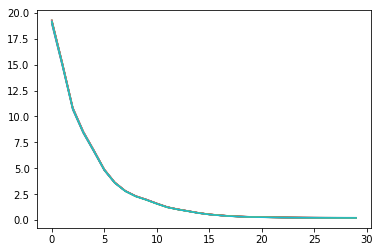

In [117]:
#lasso = LassoCV(alphas=lambdas,cv=k_fold,normalize=False,random_state=0).fit(X_train,y_train)
plt.plot(lasso.mse_path_)
plt.show()

In [128]:
ten_fold_cv_mse = [i.mean() for i in lasso.mse_path_]
ten_fold_cv_mse=pd.Series(ten_fold_cv_mse)
ten_fold_cv_mse.min()+ten_fold_cv_mse.std()

4.934970503162205

In [133]:
lambdas[25]

0.2807216203941176

In [134]:
lasso_mod = Lasso(alpha=lambdas[25]).fit(X_train,y_train)
l1pred = lasso_mod.predict(X_test)
print 'RMSE:', math.sqrt(((l1pred-y_test)**2).mean())
print 'MAE:', abs(l1pred-y_test).mean()

RMSE: 2.58036021145
MAE: 1.91806418843


In [ ]:
# deviance

#### try grid search

In [37]:
gridR = GridSearchCV(estimator=Ridge(random_state=0), \
                    param_grid=dict(alpha=lambdas), cv=k_fold)
gridR.fit(X_train, y_train)
#print grid

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00]), 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


In [38]:
print gridR.best_score_
print gridR.best_estimator_.alpha

0.9888836052799389
1.0
True


In [122]:
gridL = GridSearchCV(estimator=Lasso(random_state=0), \
                    param_grid=dict(alpha=lambdas), cv=k_fold)
gridL.fit(X_train, y_train)
#print grid

In [ ]:
print gridL.best_score_
print gridL.best_estimator_.alpha

In [18]:
list(df.columns)

['loan_amnt',
 'term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'dti_2',
 'annual_inc_2']

In [230]:
X_train_sub[['annual_inc_2', 'dti_2', 'loan_amnt', 'total_acc', 'tot_cur_bal', 'open_acc']].describe()

,annual_inc_2,dti_2,loan_amnt,total_acc,tot_cur_bal,open_acc
count,6.211650e+05,6.211650e+05,6.211650e+05,6.211650e+05,6.211650e+05,6.211650e+05
mean,-9.344674e-16,-4.565960e-16,1.272449e-17,-7.883028e-16,-4.734935e-17,1.210704e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.133713e+00,-2.186403e+00,-1.688976e+00,-2.049178e+00,-9.080027e-01,-2.172380e+00
25%,-4.658939e-01,-7.491540e-01,-8.001986e-01,-6.982083e-01,-6.906735e-01,-6.681085e-01
50%,-1.560300e-01,-5.705597e-02,-2.076803e-01,-1.071593e-01,-3.659648e-01,-1.040066e-01
75%,2.312999e-01,7.013580e-01,6.218454e-01,5.683253e-01,4.101092e-01,4.600953e-01
max,1.460223e+02,3.101998e+00,2.399400e+00,1.154495e+01,2.901613e+01,1.362247e+01


In [263]:
X_train.iloc[:,[1,3,5]].head()

,term,sub_grade,emp_length
286635,60 months,C2,9 years
303027,36 months,B1,10+ years
310502,60 months,D3,3 years
268335,36 months,C1,NaN
635606,60 months,E2,4 years


In [166]:
lm=LinearRegression().fit(X_train,y_train)
pd.DataFrame(lm.coef_,X.columns,columns=['coef'])
lm.intercept_

,coef
dti_2,0.083947
funded_amnt,0.000072


In [266]:
list(df.columns)

['loan_amnt',
 'term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'dti_2',
 'annual_inc_2',
 'addr_state_2']

In [31]:
#F = short_term.var() / long_term.var()
#stats.f.cdf(F,len(short_term)-1, len(long_term)-1)
print 'one-way ANOVA result:', stats.f_oneway(short_term,long_term)
print 'Welch t-test result:',stats.ttest_ind(short_term, long_term, equal_var=False)

one-way ANOVA result: F_onewayResult(statistic=199074.28270463392, pvalue=0.0)
Welch t-test result: Ttest_indResult(statistic=-431.11699062985156, pvalue=0.0)


In [41]:
obs = pd.crosstab(df['term'],df['grade'], margins = True)
print 'chi2 test p-value:', stats.chi2_contingency(obs)[1]

chi2 test p-value: 0.0
